**Second Method: Statistical Features and the Frequency Extraction sing FFT2** 

In [109]:
import xlsxwriter
import cv2
import numpy as np
from numpy import asarray
import pandas as pd
import pickle
from skimage import exposure, feature
from matplotlib import pyplot
from scipy.stats import skew, kurtosis
import skimage.measure    
import skimage.feature
import math
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
import os
from statistics import mean 
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import preprocessing


An image is converted from the spatial domain to the frequency domain using FFT. The examination of the image's frequency components is made possible by this change. In an image, various patterns, textures, and edges correlate to various frequencies. It can be quite important to analyze these frequencies in order to differentiate between various image classes. Certain aspects that are difficult to find in the spatial domain may become visible in the frequency domain representation. Selecting low, mid, and high frequency bands to concentrate on allows one to extract features that are pertinent to the classification task. For example, low-frequency components can depict smooth regions, whereas high-frequency components might show edges or fine features (Gonzalez & Woods, (2018)).


The function below performs the following steps:

    1. Reads the image and extracts its red channel.
    2. Calculates original statistical features from the red channel, including mean, 
       variance, skewness, kurtosis, and entropy.
    3. Extracts texture features using gray level co-occurrence matrix (GLCM) properties 
       like contrast, energy, homogeneity, and correlation.
    4. Applies FFT to the red channel and categorizes the frequency domain into low, 
       medium, and high frequency ranges. Extracts the mean and standard deviation of 
       each range as features.
    5. Appends binary and multiple labels to the features.
    6. Handles any NaN or INF values in the features, replacing them with numerical data.
    7. Reshapes the features array for compatibility with classification models.


In [110]:
def process_image(image_path, bin_label, multi_label):
    """
    Process an image to extract features using Fast Fourier Transform (FFT)
    applied to its red channel and categorize these features into different 
    frequency ranges: low, medium, and high.

    Parameters:
    - image_path (str): The file path of the image to be processed.
    - bin_label (int or float): A binary label associated with the image.
    - multi_label (int or float): A multiple class label associated with the image.


    Returns:
    - numpy.ndarray: A 2D array where each row represents the features extracted from the image, 
                     along with the provided binary and multiple labels.

    """
    img = cv2.imread(image_path)
    image = asarray(img) 
    R = image[:,:,0]
    features = np.array([])

    # Original Statistical Features
    Mean1 = np.mean(R)
    features = np.append(features, Mean1)
    Variance1 = np.var(R)
    Variance1 = math.sqrt(Variance1)
    features = np.append(features, Variance1)
    Skewness1 = skew(R.reshape(-1))
    features = np.append(features, Skewness1)
    Kurtosis1 = kurtosis(R.reshape(-1))
    features = np.append(features, Kurtosis1)
    entropy1 = skimage.measure.shannon_entropy(R)
    features = np.append(features, entropy1)

    # Texture Features
    R = skimage.img_as_ubyte(R)
    g1 = skimage.feature.graycomatrix(R, [1], [0], levels=256, symmetric=False, normed=True)
    Cont1 = skimage.feature.graycoprops(g1, 'contrast')[0][0]
    features = np.append(features, Cont1)
    Energ1 = skimage.feature.graycoprops(g1, 'energy')[0][0]
    features = np.append(features, Energ1)
    Homo1 = skimage.feature.graycoprops(g1, 'homogeneity')[0][0]
    features = np.append(features, Homo1)
    Corre1 = skimage.feature.graycoprops(g1, 'correlation')[0][0]
    features = np.append(features, Corre1)

   # Apply FFT and Extract Features
    f_transform = np.fft.fft2(R)
    f_shift = np.fft.fftshift(f_transform)
    magnitude_spectrum = (np.abs(f_shift))  # Avoid log of zero
    # Divide the spectrum into low, medium, and high frequency ranges
    (h, w) = magnitude_spectrum.shape ## it's always 128 & 128

    # Define ranges by distance from the middle of 2dFFT matrix (middle is f=0 Hz)
    low_freq_range = []
    med_freq_range = []
    high_freq_range = []

    for i in range(h):
        for j in range(w):
            if(i-65)**2 + (j-65)**2 < 4**2:
                low_freq_range.append(magnitude_spectrum[i,j])
            elif(i-65)**2 + (j-65)**2 < 9**2:
                med_freq_range.append(magnitude_spectrum[i,j])
            elif(i-65)**2 + (j-65)**2 < 35**2: #Cutting out frequencies higher than 40, which we assume is noise
                high_freq_range.append(magnitude_spectrum[i,j]) 
                 # (lowest informative freq. should be 32 because thinnest crease in the brain in the images I could find is 2 pixels wide)

    # Extract features for each range
    features = np.append(features, np.mean(low_freq_range))
    features = np.append(features, np.std(low_freq_range))
    features = np.append(features, np.mean(med_freq_range))
    features = np.append(features, np.std(med_freq_range))
    features = np.append(features, np.mean(high_freq_range))
    features = np.append(features, np.std(high_freq_range))

    # Add binary lable value
    features = np.append(features,bin_label)

    # Add multy lable value
    features = np.append(features,multy_label)


    # Handle NaN/INF values
    features = np.nan_to_num(features)  

    features = features.reshape(1, -1)

    return features


In [111]:
def process_directory(input_dir, bin_label, multy_label, out_sheet, start_row):
    """
    Process all images in a directory and write their features to an Excel sheet.

    :param input_dir: Directory containing image files.
    :param bin_label: Binary label for images in this directory.
    :param multy_label: Multiple label for images in this directory.
    :param out_sheet: The Excel worksheet to write data to.
    :param start_row: The starting row index for writing to the worksheet.
    :return: Updated row index after writing all data.
    """
    filenames = os.listdir(input_dir)
    image_filenames = sorted([f for f in filenames if f.endswith('.jpg') or f.endswith('.png')],
                             key=lambda x: int(''.join(filter(str.isdigit, x))))

    for i, filename in enumerate(image_filenames, start=start_row):
        file_path = os.path.join(input_dir, filename)
        features = process_image(file_path, bin_label, multy_label)
        out_sheet.write_row(i, 0, features[0])
    
    return i + 1  # Return the next starting row index

In [112]:
# Create Excel workbook and worksheet
outWorkbook = xlsxwriter.Workbook(r"/Users/kanykeimairambekova/Desktop/ML Project/results/All__FFT_final.xlsx")
outSheet = outWorkbook.add_worksheet()

# Write headers to the worksheet
headers = ["Mean", "Variance", "Skewness", "Kurtosis", "Contrast", "Entropy", "Energy", "Homo", "Corre","Low Freq Mean", "Low Freq Std", "Medium Freq Mean", "Medium Freq Std", "High Freq Mean", "Medium Freq Std", "Energy" "Bin_lable", "Multy_lable"]
for col, header in enumerate(headers):
    outSheet.write(0, col, header)

# Define input directories and their corresponding labels
directories = [
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Non_Demented", 0, 0),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Very_Mild_Demented", 1, 1),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Mild_Demented", 1, 2),
    (r"/Users/kanykeimairambekova/Desktop/ML Project/Dataset/Demented/Moderate_Demented", 1, 3),
]

# Process each directory and write features to the worksheet
row_index = 1  # Start writing from the second row (after headers)
for input_dir, bin_label, multy_label in directories:
    row_index = process_directory(input_dir, bin_label, multy_label, outSheet, row_index)

# Close the workbook
outWorkbook.close()

In [113]:
# Importing the dataset
dataset = pd.read_excel(r"/Users/kanykeimairambekova/Desktop/ML Project/results/All__FFT_final.xlsx")

X = dataset.iloc[:, 0:15].values
y_bin = dataset.iloc[:, 15].values

X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.25, random_state= 42, shuffle = True )

In [114]:
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.transform(X_test)

## Testing different models for classification of Demented vs Non-demented

In [115]:
# Function for metrics calculation
def metrics_calc(y_test, y_pred):
    # Confusion matrix and heatmap
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True)
    print("Confusion Matrix:\n", cm)

    # Other metrics
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))

**SVM- GridSearchCV for model and best model evaluation**

In [116]:
param_grid = {'C': [1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, verbose=3, cv=5)
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
SVM_best_model = grid.best_estimator_

# Prediction and accuracy
y_pred = SVM_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.729 total time=   0.2s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.722 total time=   0.3s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.716 total time=   0.2s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.711 total time=   0.2s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.700 total time=   0.2s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.743 total time=   0.3s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.746 total time=   0.3s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.727 total time=   0.3s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.749 total time=   0.3s
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.723 total time=   0.3s
[CV 1/5] END ....C=1, gamma=auto, kernel=linear;, score=0.729 total time=   0.2s
[CV 2/5] END ....C=1, gamma=auto, kernel=linear;

Confusion Matrix:
 [[639 188]
 [109 664]]
Accuracy: 0.814375
Precision: 0.7793427230046949
Recall: 0.8589909443725744
F1 Score: 0.8172307692307692


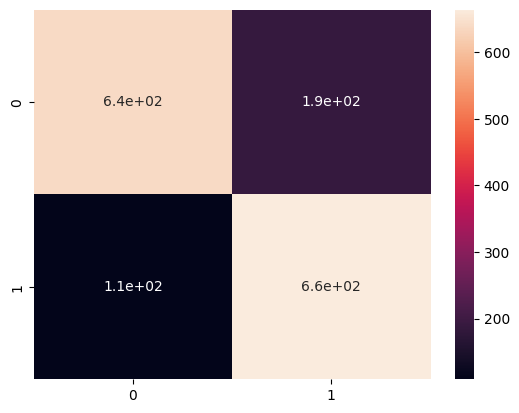

In [117]:
# Calculate evaluation metrics for SVM
metrics_calc(y_test, y_pred)

**kNN- GridSearchCV for model and best model evaluation**

In [118]:
k_range = list(range(3, 10))
leaf_range = list(range(10, 40))
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_range}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3, scoring='accuracy')
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
kNN_best_model = grid.best_estimator_

# Prediction and accuracy on the test set
y_pred = kNN_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_}'
      f'\nAccuracy for 5-fold CV: {grid.best_score_}'
      f'\nAccuracy for the test set: {accuracy}')
    

Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV 1/5] END .......leaf_size=10, n_neighbors=3;, score=0.830 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=3;, score=0.814 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=3;, score=0.835 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=3;, score=0.828 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=3;, score=0.815 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=4;, score=0.822 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=4;, score=0.785 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=4;, score=0.795 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=4;, score=0.794 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=4;, score=0.802 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=5;, score=0.801 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors

Confusion Matrix:
 [[685 142]
 [134 639]]
Accuracy: 0.8275
Precision: 0.8181818181818182
Recall: 0.8266494178525227
F1 Score: 0.8223938223938224


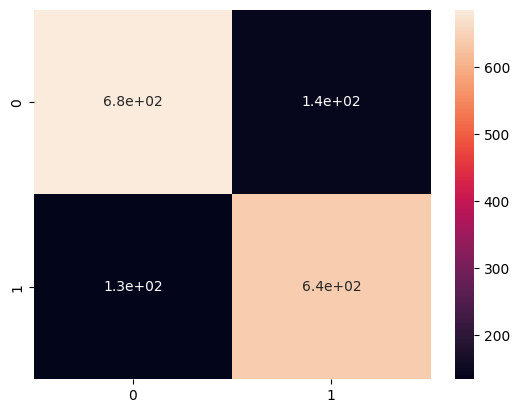

In [119]:
# Calculate evaluation metrics for kNN
metrics_calc(y_test, y_pred) 

**Gaussian NB- GridSearchCV for model and best model evaluation**

In [120]:
param_grid = {
            'priors': [None],
            'var_smoothing': [1e-9, 1e-6, 1e-12],
         }
grid = GridSearchCV(GaussianNB(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

Gaussian_NB_best_model = grid.best_estimator_
Gaussian_NB_best_model.fit(X_train_norm, y_train)
y_pred = Gaussian_NB_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..priors=None, var_smoothing=1e-09;, score=0.685 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-09;, score=0.674 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-09;, score=0.675 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-09;, score=0.666 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-09;, score=0.668 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-06;, score=0.685 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-06;, score=0.674 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-06;, score=0.675 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-06;, score=0.666 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-06;, score=0.668 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-12;, score=0.685 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-12;,

Confusion Matrix:
 [[585 242]
 [257 516]]
Accuracy: 0.688125
Precision: 0.6807387862796834
Recall: 0.6675291073738681
F1 Score: 0.674069235793599


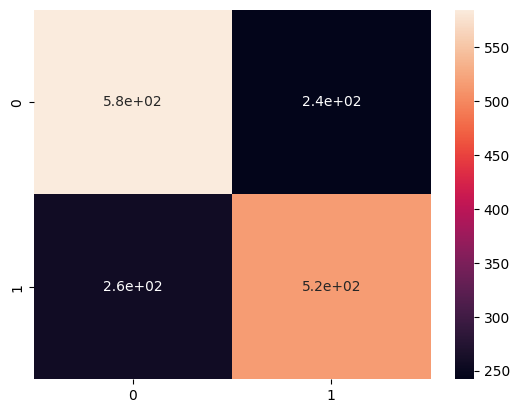

In [121]:
# Calculate evaluation metrics for NB
metrics_calc(y_test, y_pred) 

**LR- GridSearchCV for model and best model evaluation**

In [122]:
# LR Classifier 
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l2"], 'tol' : [0.0001, 0.001, 0.01, 0.1], 'max_iter':[1000, 10000]}
grid = GridSearchCV( LogisticRegression(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

LR_best_model = grid.best_estimator_
LR_best_model.fit(X_train_norm, y_train)
y_pred = LR_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.700 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.707 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.685 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.689 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.700 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.707 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.695 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.685 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.689 total time=   0.0s
[CV 1/5] END 

Confusion Matrix:
 [[563 264]
 [176 597]]
Accuracy: 0.725
Precision: 0.6933797909407665
Recall: 0.7723156532988357
F1 Score: 0.7307221542227662


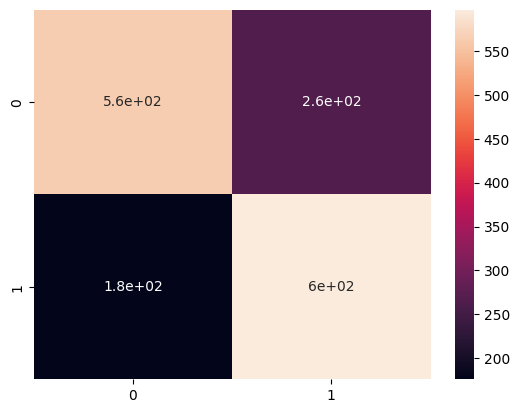

In [123]:
# Calculate evaluation metrics for LR
metrics_calc(y_test, y_pred)

**Decision Tree- GridSearchCV for model and best model evaluation**

In [124]:
param_grid = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [4, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0.1, 0.25, 0.5]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

DTree_best_model = grid.best_estimator_
DTree_best_model.fit(X_train_norm, y_train)
y_pred = DTree_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.699 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.708 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.694 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.682 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.684 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.694 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.711 total time=   0.0s
[CV 3/5] END max_depth=2, min_sa

Confusion Matrix:
 [[536 291]
 [198 575]]
Accuracy: 0.694375
Precision: 0.663972286374134
Recall: 0.7438551099611902
F1 Score: 0.7016473459426479


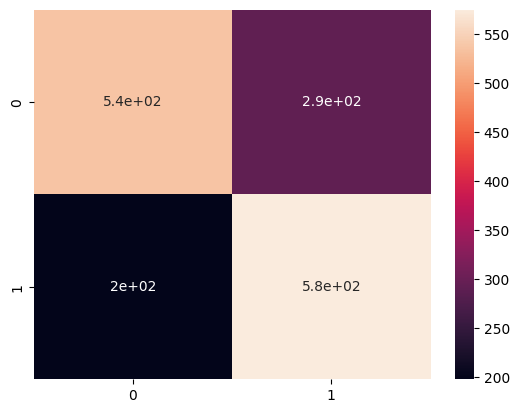

In [125]:
# Calculate evaluation metrics for DT
metrics_calc(y_test, y_pred)

**Random Forest- fitting the model and evaluation**

In [126]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)
grid.fit(X_train_norm, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_norm)
accuracy2 = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy2} ')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.724 total time=   0.6s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.736 total time=   0.6s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.710 total time=   0.5s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.707 total time=   0.5s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.690 total time=   0.5s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.723 total time=   1.4s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.734 total time=   1.4s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.710 total time=   1.4s
[CV 4/5] END criterion=gini, max_depth=4, max_feat

Confusion Matrix:
 [[555 272]
 [147 626]]
Accuracy: 0.738125
Precision: 0.6971046770601337
Recall: 0.8098318240620958
F1 Score: 0.7492519449431477


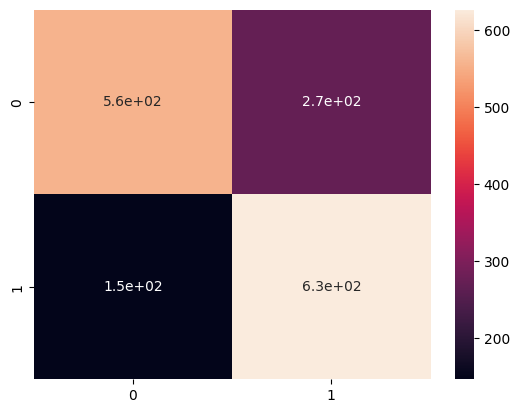

In [127]:
# Calculate evaluation metrics for RF
metrics_calc(y_test, y_pred)

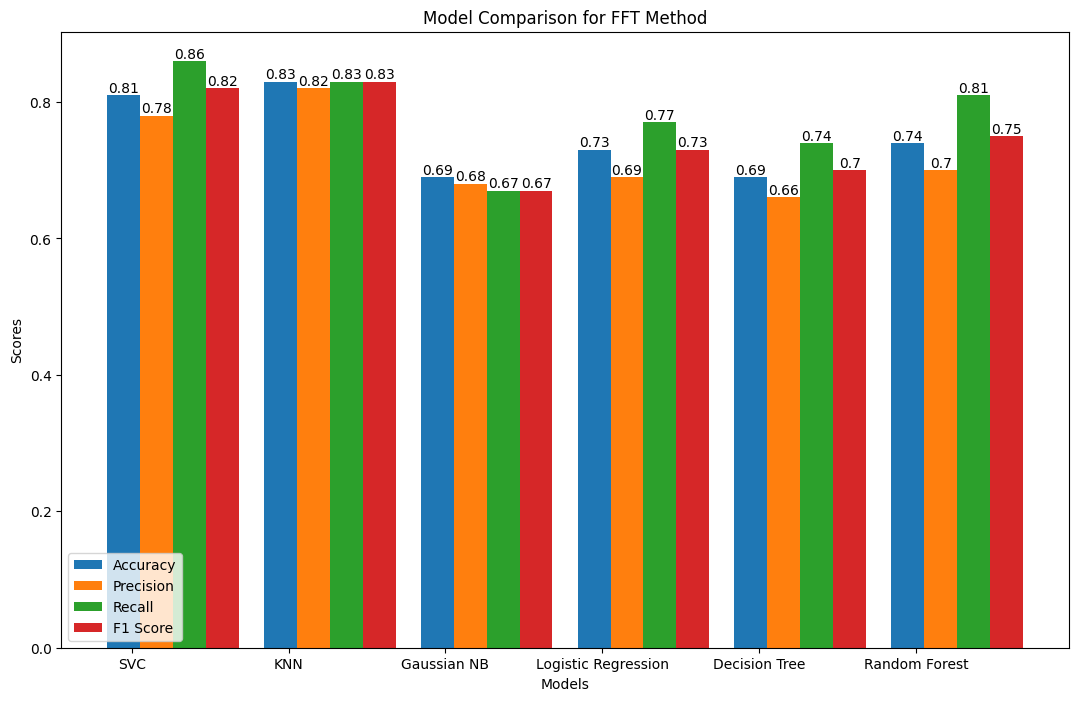

In [143]:
metrics = {
    'SVC': {
        'Accuracy': 0.81,  
        'Precision': 0.78,  
        'Recall': 0.86,  
        'F1 Score': 0.82  
    },
    'KNN': {
        'Accuracy': 0.83,
        'Precision': 0.82,
        'Recall': 0.83,
        'F1 Score': 0.83
    },
    'Gaussian NB': {
        'Accuracy': 0.69,
        'Precision': 0.68,
        'Recall': 0.67,
        'F1 Score': 0.67
    },
    'Logistic Regression': {
        'Accuracy': 0.73,
        'Precision': 0.69,
        'Recall': 0.77,
        'F1 Score': 0.73
    },
    'Decision Tree': {
        'Accuracy': 0.69,
        'Precision': 0.66,
        'Recall': 0.74,
        'F1 Score': 0.70
    },
    'Random Forest': {
        'Accuracy': 0.74,
        'Precision': 0.70,
        'Recall': 0.81,
        'F1 Score': 0.75
    },
    
}

fig, ax = plt.subplots(figsize=(13, 8))
model_names = list(metrics.keys())
metric_names = list(metrics[next(iter(metrics))].keys())
metric_values = np.array([[metrics[model][metric] for metric in metric_names] for model in model_names])

n_models = len(model_names)
n_metrics = len(metric_names)

bar_width = 0.21
indices = np.arange(n_models)

for i in range(n_metrics):
    bars = ax.bar(indices + i * bar_width, metric_values[:, i], bar_width, label=metric_names[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison for FFT Method')
ax.set_xticks(indices + bar_width / n_metrics)
ax.set_xticklabels(model_names)

ax.legend(loc='lower left')

plt.show()


## Testing different models for classification of Non-demented vs Moderately demented

(Using features from 'x_non_vs_mod' and targets from 'y_non_vs_mod', which I created in the begining)

In [128]:
# Create dataset only to compare non-demented vs moderatly
x_non_vs_mod = dataset.drop(dataset.index[64:-64]).iloc[:, 0:15].values
y_non_vs_mod = dataset.drop(dataset.index[64:-64]).iloc[:, 15].values
print(len(x_non_vs_mod))
print(len(y_non_vs_mod))
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_non_vs_mod, y_non_vs_mod, test_size = 0.25, random_state=42, shuffle = True )

128
128


In [129]:
# Normalizing features
sc = StandardScaler()
X_train_norm = sc.fit_transform(X_train)
X_test_norm = sc.fit_transform(X_test)
X_total_norm = sc.fit_transform(x_non_vs_mod) 

**SVM- GridSearchCV for model and best model evaluation**

In [130]:
param_grid = {'C': [1, 10, 50, 100], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'rbf']}
grid = GridSearchCV(SVC(), param_grid, verbose=3, cv=5)
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
SVM_best_model = grid.best_estimator_

# Prediction and accuracy
y_pred = SVM_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END ...C=1, gamma=scale, kernel=linear;, score=0.950 total time=   0.0s
[CV 2/5] END ...C=1, gamma=scale, kernel=linear;, score=0.947 total time=   0.0s
[CV 3/5] END ...C=1, gamma=scale, kernel=linear;, score=0.895 total time=   0.0s
[CV 4/5] END ...C=1, gamma=scale, kernel=linear;, score=0.895 total time=   0.0s
[CV 5/5] END ...C=1, gamma=scale, kernel=linear;, score=0.895 total time=   0.0s
[CV 1/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.800 total time=   0.0s
[CV 2/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.895 total time=   0.0s
[CV 3/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.895 total time=   0.0s
[CV 4/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.895 total time=   0.0s
[CV 5/5] END ......C=1, gamma=scale, kernel=rbf;, score=0.895 total time=   0.0s
[CV 1/5] END ....C=1, gamma=auto, kernel=linear;, score=0.950 total time=   0.0s
[CV 2/5] END ....C=1, gamma=auto, kernel=linear;

Confusion Matrix:
 [[17  0]
 [ 0 15]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


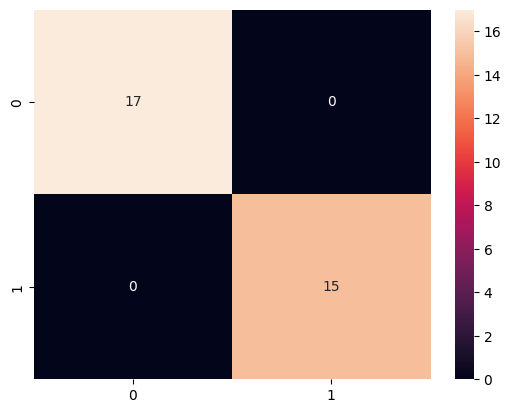

In [131]:
# Calculate evaluation metrics for SVM
metrics_calc(y_test, y_pred)

**kNN- GridSearchCV for model and best model evaluation**

In [132]:
k_range = list(range(3, 10))
leaf_range = list(range(10, 40))
param_grid = {'n_neighbors': k_range, 'leaf_size': leaf_range}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3, scoring='accuracy')
grid.fit(X_train_norm, y_train)

# Best model from GridSearch
kNN_best_model = grid.best_estimator_

# Prediction and accuracy on the test set
y_pred = kNN_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_}'
      f'\nAccuracy for 5-fold CV: {grid.best_score_}'
      f'\nAccuracy for the test set: {accuracy}')
     


Fitting 5 folds for each of 210 candidates, totalling 1050 fits
[CV 1/5] END .......leaf_size=10, n_neighbors=3;, score=0.850 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=3;, score=0.895 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=3;, score=1.000 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=3;, score=0.895 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=3;, score=0.895 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=4;, score=0.850 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors=4;, score=0.947 total time=   0.0s
[CV 3/5] END .......leaf_size=10, n_neighbors=4;, score=0.947 total time=   0.0s
[CV 4/5] END .......leaf_size=10, n_neighbors=4;, score=0.895 total time=   0.0s
[CV 5/5] END .......leaf_size=10, n_neighbors=4;, score=0.895 total time=   0.0s
[CV 1/5] END .......leaf_size=10, n_neighbors=5;, score=0.950 total time=   0.0s
[CV 2/5] END .......leaf_size=10, n_neighbors

Confusion Matrix:
 [[16  1]
 [ 0 15]]
Accuracy: 0.96875
Precision: 0.9375
Recall: 1.0
F1 Score: 0.967741935483871


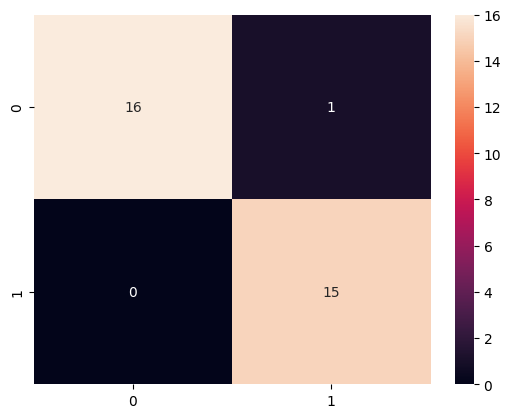

In [133]:
# Calculate evaluation metrics for kNN
metrics_calc(y_test, y_pred) 

**Gaussian NB- GridSearchCV for model and best model evaluation**

In [134]:
param_grid = {
            'priors': [None],
            'var_smoothing': [1e-9, 1e-6, 1e-12],
         }
grid = GridSearchCV(GaussianNB(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

Gaussian_NB_best_model = grid.best_estimator_
Gaussian_NB_best_model.fit(X_train_norm, y_train)
y_pred = Gaussian_NB_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..priors=None, var_smoothing=1e-09;, score=0.850 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-09;, score=0.789 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-09;, score=0.947 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-09;, score=0.947 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-09;, score=0.842 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-06;, score=0.850 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-06;, score=0.789 total time=   0.0s
[CV 3/5] END ..priors=None, var_smoothing=1e-06;, score=0.947 total time=   0.0s
[CV 4/5] END ..priors=None, var_smoothing=1e-06;, score=0.947 total time=   0.0s
[CV 5/5] END ..priors=None, var_smoothing=1e-06;, score=0.842 total time=   0.0s
[CV 1/5] END ..priors=None, var_smoothing=1e-12;, score=0.850 total time=   0.0s
[CV 2/5] END ..priors=None, var_smoothing=1e-12;,

Confusion Matrix:
 [[15  2]
 [ 2 13]]
Accuracy: 0.875
Precision: 0.8666666666666667
Recall: 0.8666666666666667
F1 Score: 0.8666666666666667


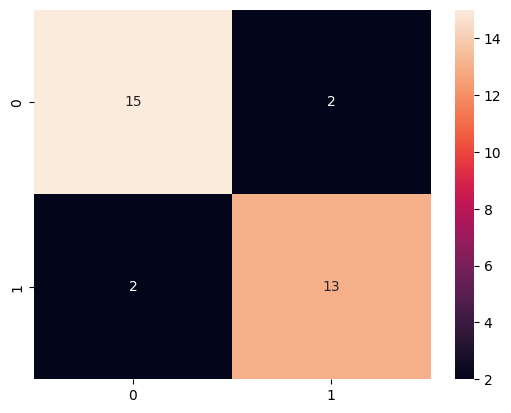

In [135]:
# Calculate evaluation metrics for NB
metrics_calc(y_test, y_pred) 

**LR- GridSearchCV for model and best model evaluation**

In [136]:
# LR Classifier 
param_grid = {"C":np.logspace(-3,3,7), "penalty":["l2"], 'tol' : [0.0001, 0.001, 0.01, 0.1], 'max_iter':[1000, 10000]}
grid = GridSearchCV( LogisticRegression(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

LR_best_model = grid.best_estimator_
LR_best_model.fit(X_train_norm, y_train)
y_pred = LR_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 56 candidates, totalling 280 fits
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.800 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.789 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.947 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.842 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.0001;, score=0.737 total time=   0.0s
[CV 1/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.800 total time=   0.0s
[CV 2/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.789 total time=   0.0s
[CV 3/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.947 total time=   0.0s
[CV 4/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.842 total time=   0.0s
[CV 5/5] END C=0.001, max_iter=1000, penalty=l2, tol=0.001;, score=0.737 total time=   0.0s
[CV 1/5] END 

Confusion Matrix:
 [[17  0]
 [ 1 14]]
Accuracy: 0.96875
Precision: 1.0
Recall: 0.9333333333333333
F1 Score: 0.9655172413793104


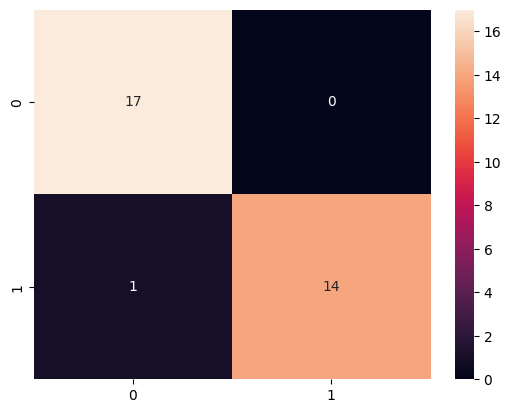

In [137]:
# Calculate evaluation metrics for LR
metrics_calc(y_test, y_pred)

**Decision Tree- GridSearchCV for model and best model evaluation**

In [138]:
param_grid = {'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [4, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_weight_fraction_leaf': [0.1, 0.25, 0.5]}
grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3, scoring = 'accuracy')
grid.fit(X_train_norm, y_train)

DTree_best_model = grid.best_estimator_
DTree_best_model.fit(X_train_norm, y_train)
y_pred = DTree_best_model.predict(X_test_norm)
accuracy = accuracy_score(y_test, y_pred)


print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy}')

Fitting 5 folds for each of 135 candidates, totalling 675 fits
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.750 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.737 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.737 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.895 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.1;, score=0.895 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.750 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.25;, score=0.737 total time=   0.0s
[CV 3/5] END max_depth=2, min_sa

Confusion Matrix:
 [[14  3]
 [ 1 14]]
Accuracy: 0.875
Precision: 0.8235294117647058
Recall: 0.9333333333333333
F1 Score: 0.8749999999999999


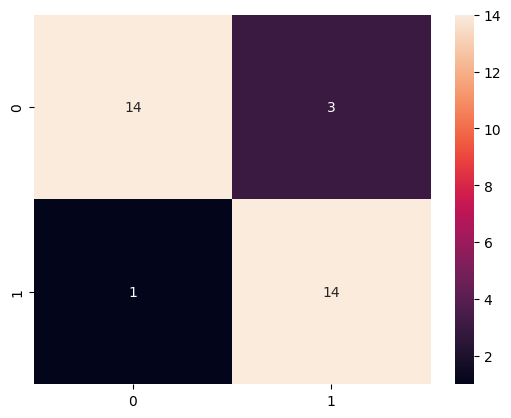

In [139]:
# Calculate evaluation metrics for DT
metrics_calc(y_test, y_pred)

**Random Forest- fitting the model and evaluation**

In [140]:
param_grid = {
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 5, 6, 7, 8],
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)
grid.fit(X_train_norm, y_train)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test_norm)
accuracy2 = accuracy_score(y_test, y_pred)

print(f'Best parameters: {grid.best_params_} \n Accuracy for 5 fold CV: {grid.best_score_} \n Accuracy for the test set is: {accuracy2} ')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.850 total time=   0.1s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.895 total time=   0.1s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.947 total time=   0.1s
[CV 4/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.947 total time=   0.1s
[CV 5/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200;, score=0.947 total time=   0.1s
[CV 1/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.800 total time=   0.2s
[CV 2/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.895 total time=   0.2s
[CV 3/5] END criterion=gini, max_depth=4, max_features=sqrt, n_estimators=500;, score=0.947 total time=   0.2s
[CV 4/5] END criterion=gini, max_depth=4, max_feat

Confusion Matrix:
 [[17  0]
 [ 0 15]]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


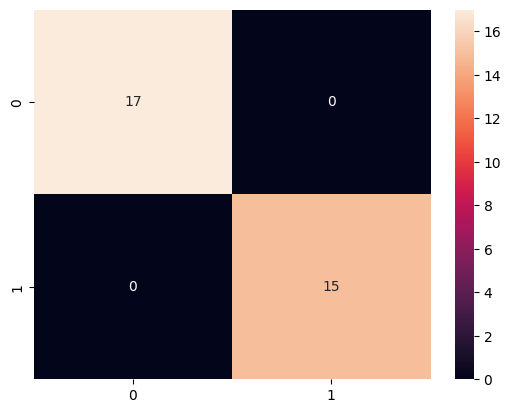

In [141]:
# Calculate evaluation metrics for RF
metrics_calc(y_test, y_pred)

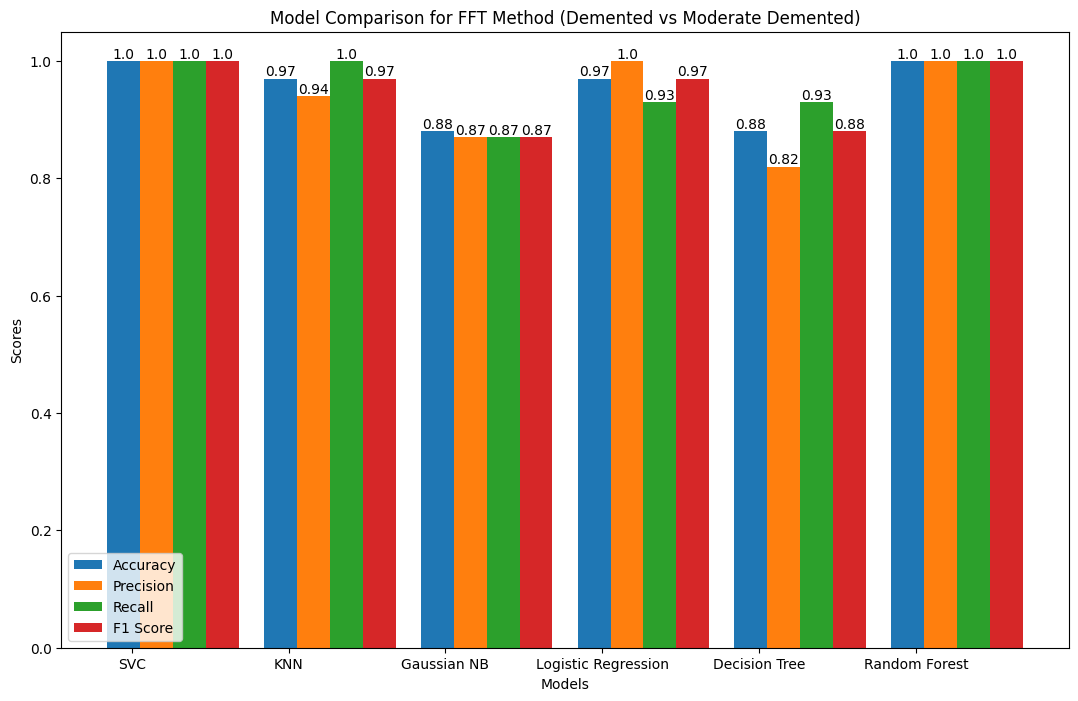

In [144]:
metrics = {
    'SVC': {
        'Accuracy': 1.0,  
        'Precision': 1.0,  
        'Recall': 1.0,  
        'F1 Score': 1.0  
    },
    'KNN': {
        'Accuracy': 0.97,
        'Precision': 0.94,
        'Recall': 1.0,
        'F1 Score': 0.97
    },
    'Gaussian NB': {
        'Accuracy': 0.88,
        'Precision': 0.87,
        'Recall': 0.87,
        'F1 Score': 0.87
    },
    'Logistic Regression': {
        'Accuracy': 0.97,
        'Precision': 1.0,
        'Recall': 0.93,
        'F1 Score': 0.97
    },
    'Decision Tree': {
        'Accuracy': 0.88,
        'Precision': 0.82,
        'Recall': 0.93,
        'F1 Score': 0.88
    },
    'Random Forest': {
        'Accuracy': 1.0,  
        'Precision': 1.0,  
        'Recall': 1.0,  
        'F1 Score': 1.0 
    },
    
}

fig, ax = plt.subplots(figsize=(13, 8))
model_names = list(metrics.keys())
metric_names = list(metrics[next(iter(metrics))].keys())
metric_values = np.array([[metrics[model][metric] for metric in metric_names] for model in model_names])

n_models = len(model_names)
n_metrics = len(metric_names)

bar_width = 0.21
indices = np.arange(n_models)

for i in range(n_metrics):
    bars = ax.bar(indices + i * bar_width, metric_values[:, i], bar_width, label=metric_names[i])
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Comparison for FFT Method (Demented vs Moderate Demented)')
ax.set_xticks(indices + bar_width / n_metrics)
ax.set_xticklabels(model_names)

ax.legend(loc='lower left')

plt.show()


References: 

Gonzalez, R. C., & Woods, R. E. (2018). Digital Image Processing (4th ed.). Pearson. [For general concepts of frequency domain analysis and FFT in image processing]